In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import traceback
import time
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

In [2]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [3]:
path = "/Users/Lane/Downloads/g-research-crypto-forecasting/"
df_train = pd.read_csv(path + "train.csv")
df_test = pd.read_csv(path + "example_test.csv")
df_asset_details = pd.read_csv(path + "asset_details.csv")
df_supp_train = pd.read_csv(path + "supplemental_train.csv")

In [4]:
df_train.head()

,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
0,1514764860,2,40.0,2376.5800,2399.5000,2357.1400,2374.5900,19.233005,2373.116392,-0.004218
1,1514764860,0,5.0,8.5300,8.5300,8.5300,8.5300,78.380000,8.530000,-0.014399
2,1514764860,1,229.0,13835.1940,14013.8000,13666.1100,13850.1760,31.550062,13827.062093,-0.014643
3,1514764860,5,32.0,7.6596,7.6596,7.6567,7.6576,6626.713370,7.657713,-0.013922
4,1514764860,7,5.0,25.9200,25.9200,25.8740,25.8770,121.087310,25.891363,-0.008264


In [5]:
df_train.shape

(24236806, 10)

In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24236806 entries, 0 to 24236805
Data columns (total 10 columns):
 #   Column     Dtype  
---  ------     -----  
 0   timestamp  int64  
 1   Asset_ID   int64  
 2   Count      float64
 3   Open       float64
 4   High       float64
 5   Low        float64
 6   Close      float64
 7   Volume     float64
 8   VWAP       float64
 9   Target     float64
dtypes: float64(8), int64(2)
memory usage: 1.8 GB


In [7]:
df_train.isnull().sum()

timestamp         0
Asset_ID          0
Count             0
Open              0
High              0
Low               0
Close             0
Volume            0
VWAP              9
Target       750338
dtype: int64

In [8]:
##df_train.dropna(how='any', inplace=True)

In [9]:
df_train.isnull().sum()

timestamp         0
Asset_ID          0
Count             0
Open              0
High              0
Low               0
Close             0
Volume            0
VWAP              9
Target       750338
dtype: int64

In [10]:
df_train.describe()

,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
count,2.423681e+07,2.423681e+07,2.423681e+07,2.423681e+07,2.423681e+07,2.423681e+07,2.423681e+07,2.423681e+07,2.423680e+07,2.348647e+07
mean,1.577120e+09,6.292544e+00,2.864593e+02,1.432640e+03,1.436350e+03,1.429568e+03,1.432640e+03,2.868530e+05,NaN,7.121752e-06
std,3.323350e+07,4.091861e+00,8.673982e+02,6.029605e+03,6.039482e+03,6.020261e+03,6.029611e+03,2.433935e+06,NaN,5.679042e-03
min,1.514765e+09,0.000000e+00,1.000000e+00,1.170400e-03,1.195000e-03,2.000000e-04,1.171400e-03,-3.662812e-01,-inf,-5.093509e-01
25%,1.549011e+09,3.000000e+00,1.900000e+01,2.676500e-01,2.681600e-01,2.669000e-01,2.676483e-01,1.410725e+02,2.676368e-01,-1.694354e-03
50%,1.578372e+09,6.000000e+00,6.400000e+01,1.428860e+01,1.431250e+01,1.426300e+01,1.428920e+01,1.295415e+03,1.428769e+01,-4.289844e-05
75%,1.606198e+09,9.000000e+00,2.210000e+02,2.288743e+02,2.293000e+02,2.284200e+02,2.288729e+02,2.729764e+04,2.288728e+02,1.601520e-03
max,1.632182e+09,1.300000e+01,1.650160e+05,6.480594e+04,6.490000e+04,6.467053e+04,6.480854e+04,7.597554e+08,inf,9.641699e-01


In [11]:
df_test.head()

,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,group_num,row_id
0,1623542400,3,1201.0,1.478556,1.48603,1.47800,1.483681,654799.561103,1.481439,0,0
1,1623542400,2,1020.0,580.306667,583.89000,579.91000,582.276667,1227.988328,581.697038,0,1
2,1623542400,0,626.0,343.789500,345.10800,343.64000,344.598000,1718.832569,344.441729,0,2
3,1623542400,1,2888.0,35554.289632,35652.46465,35502.67000,35602.004286,163.811537,35583.469303,0,3
4,1623542400,4,433.0,0.312167,0.31260,0.31192,0.312208,585577.410442,0.312154,0,4


In [12]:
df_test.shape

(56, 11)

In [13]:
df_asset_details

,Asset_ID,Weight,Asset_Name
0,2,2.397895,Bitcoin Cash
1,0,4.304065,Binance Coin
2,1,6.779922,Bitcoin
3,5,1.386294,EOS.IO
4,7,2.079442,Ethereum Classic
5,6,5.894403,Ethereum
6,9,2.397895,Litecoin
7,11,1.609438,Monero
8,13,1.791759,TRON
9,12,2.079442,Stellar


In [14]:
df_supp_train

,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
0,1623542400,3,1201.0,1.478556,1.486030,1.478000,1.483681,6.547996e+05,1.481439,-0.002594
1,1623542400,2,1020.0,580.306667,583.890000,579.910000,582.276667,1.227988e+03,581.697038,-0.009143
2,1623542400,0,626.0,343.789500,345.108000,343.640000,344.598000,1.718833e+03,344.441729,-0.004525
3,1623542400,1,2888.0,35554.289632,35652.464650,35502.670000,35602.004286,1.638115e+02,35583.469303,0.003096
4,1623542400,4,433.0,0.312167,0.312600,0.311920,0.312208,5.855774e+05,0.312154,0.001426
...,...,...,...,...,...,...,...,...,...,...
2015107,1632182400,9,775.0,157.181571,157.250000,156.700000,156.943857,4.663725e+03,156.994319,NaN
2015108,1632182400,10,34.0,2437.065067,2438.000000,2430.226900,2432.907467,3.975460e+00,2434.818747,NaN
2015109,1632182400,13,380.0,0.091390,0.091527,0.091260,0.091349,2.193732e+06,0.091388,NaN
2015110,1632182400,12,177.0,0.282168,0.282438,0.281842,0.282051,1.828508e+05,0.282134,NaN


In [15]:
df_supp_train.isnull().sum()

timestamp       0
Asset_ID        0
Count           0
Open            0
High            0
Low             0
Close           0
Volume          0
VWAP            0
Target       1735
dtype: int64

In [16]:
df_train = df_train.dropna()

In [17]:
df_train.Asset_ID.value_counts()

1     1955978
6     1955860
9     1955509
5     1952838
2     1948676
7     1941801
0     1929204
13    1853546
3     1773136
12    1716933
11    1461658
8     1398965
4     1011892
10     630469
Name: Asset_ID, dtype: int64

In [18]:
asset_names_dict = {row["Asset_Name"]:row["Asset_ID"] for ind, row in df_asset_details.iterrows()}

asset_names = [
    'Bitcoin',
    'Ethereum',
    'Cardano',
    'Binance Coin',
    'Dogecoin',
    'Bitcoin Cash',
    'Litecoin',
    'Ethereum Classic',
    'Stellar',
    'TRON',
    'Monero',
    'EOS.IO',
    'IOTA',
    'Maker'
]

time_list = []
for coin in asset_names:
    coin_df = df_train[df_train["Asset_ID"]==asset_names_dict[coin]].set_index("timestamp")
    start_time = coin_df.index[0].astype('datetime64[s]')
    end_time = coin_df.index[-1].astype('datetime64[s]')
    time_list.append([coin, start_time, end_time])
time_df = pd.DataFrame(time_list)
time_df.columns = ["Asset_Name", "Start_Time", "End_Time"]
time_df

,Asset_Name,Start_Time,End_Time
0,Bitcoin,2018-01-01 00:01:00,2021-09-20 23:44:00
1,Ethereum,2018-01-01 00:01:00,2021-09-20 23:44:00
2,Cardano,2018-04-17 09:11:00,2021-09-20 23:44:00
3,Binance Coin,2018-01-01 00:01:00,2021-09-20 23:44:00
4,Dogecoin,2019-04-12 14:34:00,2021-09-20 23:44:00
5,Bitcoin Cash,2018-01-01 00:01:00,2021-09-20 23:44:00
6,Litecoin,2018-01-01 00:01:00,2021-09-20 23:44:00
7,Ethereum Classic,2018-01-01 00:01:00,2021-09-20 23:44:00
8,Stellar,2018-02-17 00:51:00,2021-09-20 23:44:00
9,TRON,2018-02-06 21:37:00,2021-09-20 23:44:00


In [19]:
btc = df_train[df_train['Asset_ID'] == 1]
btcC = df_train[df_train['Asset_ID'] == 2]
bic = df_train[df_train['Asset_ID'] == 0]
eos = df_train[df_train['Asset_ID'] == 5]
ethC = df_train[df_train['Asset_ID'] == 7]
eth = df_train[df_train['Asset_ID'] == 6]
ltc = df_train[df_train['Asset_ID'] == 9]
mon = df_train[df_train['Asset_ID'] == 11]
tron = df_train[df_train['Asset_ID'] == 13]
stl = df_train[df_train['Asset_ID'] == 12]
car = df_train[df_train['Asset_ID'] == 3]
iota = df_train[df_train['Asset_ID'] == 8]
mak = df_train[df_train['Asset_ID'] == 10]
doge = df_train[df_train['Asset_ID'] == 4]

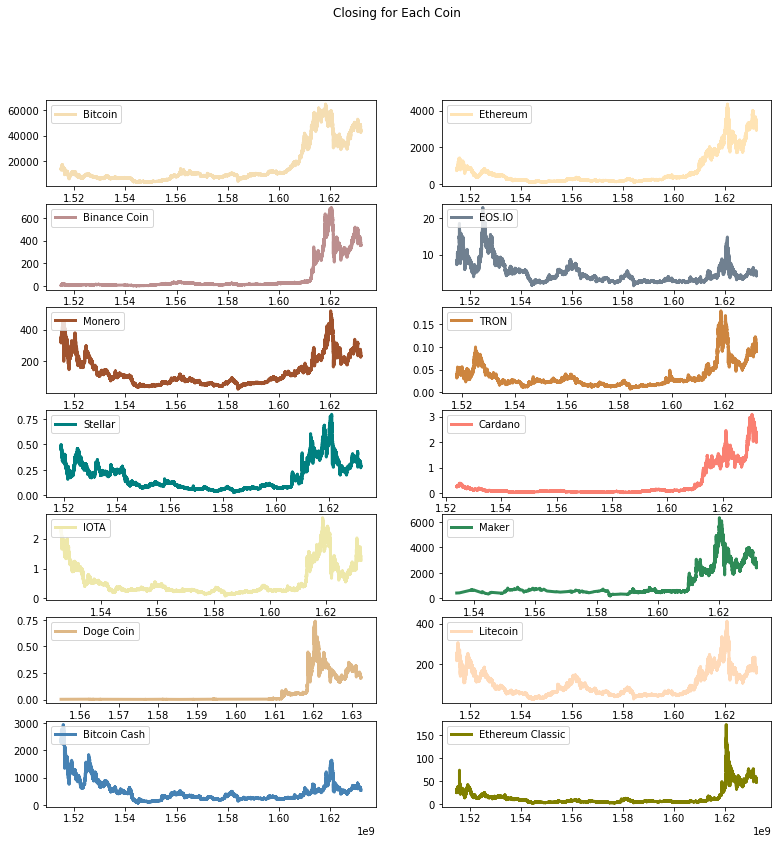

In [33]:
plt.subplots(figsize = (13,13))

plt.subplot(7,2,1)
plt.plot(btc.timestamp, btc.Close, color = 'wheat', label='Bitcoin', linewidth=3)
plt.legend(loc='upper left')

plt.subplot(7,2,2)
plt.plot(eth.timestamp, eth.Close, color='moccasin', label='Ethereum', linewidth=3)
plt.legend(loc='upper left')

plt.subplot(7,2,3)
plt.plot(bic.timestamp, bic.Close, color='rosybrown', label='Binance Coin', linewidth=3)
plt.legend(loc='upper left')

plt.subplot(7,2,4)
plt.plot(eos.timestamp, eos.Close, color='slategrey', label='EOS.IO', linewidth=3)
plt.legend(loc='upper left')

plt.subplot(7,2,5)
plt.plot(mon.timestamp, mon.Close, color='sienna', label='Monero', linewidth=3)
plt.legend(loc='upper left')

plt.subplot(7,2,6)
plt.plot(tron.timestamp, tron.Close, color='peru', label='TRON', linewidth=3)
plt.legend(loc='upper left')

plt.subplot(7,2,7)
plt.plot(stl.timestamp, stl.Close, color='teal', label='Stellar', linewidth=3)
plt.legend(loc='upper left')

plt.subplot(7,2,8)
plt.plot(car.timestamp, car.Close, color='salmon', label='Cardano', linewidth=3)
plt.legend(loc='upper left')

plt.subplot(7,2,9)
plt.plot(iota.timestamp, iota.Close, color='palegoldenrod', label='IOTA', linewidth=3)
plt.legend(loc='upper left')

plt.subplot(7,2,10)
plt.plot(mak.timestamp, mak.Close, color='seagreen', label='Maker', linewidth=3)
plt.legend(loc='upper left')

plt.subplot(7,2,11)
plt.plot(doge.timestamp, doge.Close, color='burlywood', label='Doge Coin', linewidth=3)
plt.legend(loc='upper left')

plt.subplot(7,2,12)
plt.plot(ltc.timestamp, ltc.Close, color='peachpuff', label='Litecoin', linewidth=3)
plt.legend(loc='upper left')

plt.subplot(7,2,13)
plt.plot(btcC.timestamp, btcC.Close, color='steelblue', label='Bitcoin Cash', linewidth=3)
plt.legend(loc='upper left')

plt.subplot(7,2,14)
plt.plot(ethC.timestamp, ethC.Close, color='olive', label='Ethereum Classic', linewidth=3)
plt.legend(loc='upper left')


plt.suptitle('Closing for Each Coin')
##plt.xlabel('Timestamp')
##plt.ylabel('Close')

plt.legend()


plt.show() 

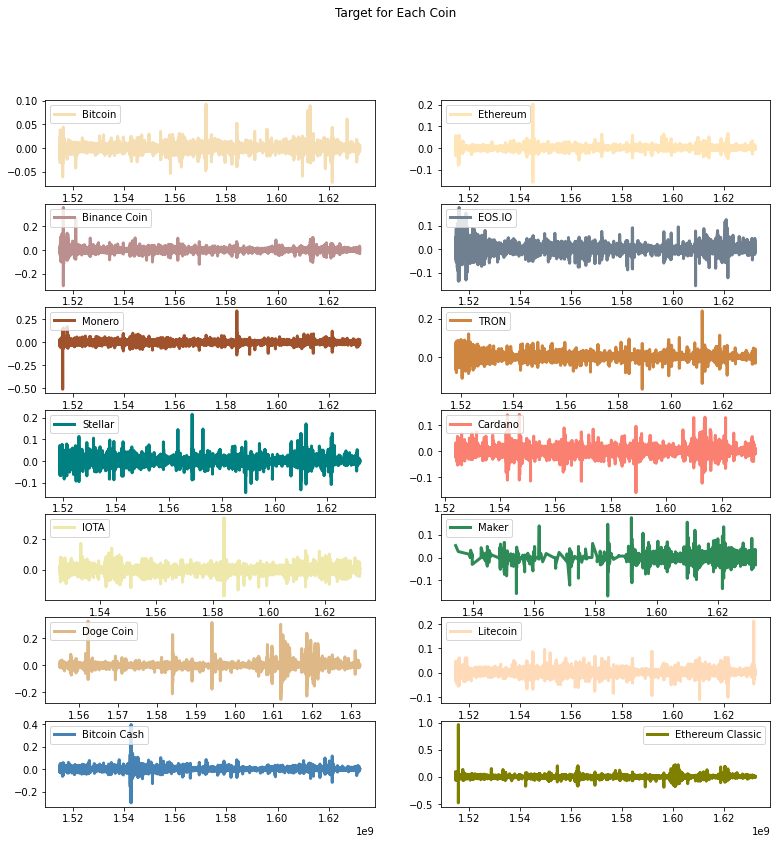

In [34]:
plt.subplots(figsize = (13,13))

plt.subplot(7,2,1)
plt.plot(btc.timestamp, btc.Target, color = 'wheat', label='Bitcoin', linewidth=3)
plt.legend(loc='upper left')

plt.subplot(7,2,2)
plt.plot(eth.timestamp, eth.Target, color='moccasin', label='Ethereum', linewidth=3)
plt.legend(loc='upper left')

plt.subplot(7,2,3)
plt.plot(bic.timestamp, bic.Target, color='rosybrown', label='Binance Coin', linewidth=3)
plt.legend(loc='upper left')

plt.subplot(7,2,4)
plt.plot(eos.timestamp, eos.Target, color='slategrey', label='EOS.IO', linewidth=3)
plt.legend(loc='upper left')

plt.subplot(7,2,5)
plt.plot(mon.timestamp, mon.Target, color='sienna', label='Monero', linewidth=3)
plt.legend(loc='upper left')

plt.subplot(7,2,6)
plt.plot(tron.timestamp, tron.Target, color='peru', label='TRON', linewidth=3)
plt.legend(loc='upper left')

plt.subplot(7,2,7)
plt.plot(stl.timestamp, stl.Target, color='teal', label='Stellar', linewidth=3)
plt.legend(loc='upper left')

plt.subplot(7,2,8)
plt.plot(car.timestamp, car.Target, color='salmon', label='Cardano', linewidth=3)
plt.legend(loc='upper left')

plt.subplot(7,2,9)
plt.plot(iota.timestamp, iota.Target, color='palegoldenrod', label='IOTA', linewidth=3)
plt.legend(loc='upper left')

plt.subplot(7,2,10)
plt.plot(mak.timestamp, mak.Target, color='seagreen', label='Maker', linewidth=3)
plt.legend(loc='upper left')

plt.subplot(7,2,11)
plt.plot(doge.timestamp, doge.Target, color='burlywood', label='Doge Coin', linewidth=3)
plt.legend(loc='upper left')

plt.subplot(7,2,12)
plt.plot(ltc.timestamp, ltc.Target, color='peachpuff', label='Litecoin', linewidth=3)
plt.legend(loc='upper left')

plt.subplot(7,2,13)
plt.plot(btcC.timestamp, btcC.Target, color='steelblue', label='Bitcoin Cash', linewidth=3)
plt.legend(loc='upper left')

plt.subplot(7,2,14)
plt.plot(ethC.timestamp, ethC.Target, color='olive', label='Ethereum Classic', linewidth=3)
plt.legend(loc='upper left')


plt.suptitle('Target for Each Coin')
##plt.xlabel('Timestamp')
##plt.ylabel('Close')

plt.legend()


plt.show() 

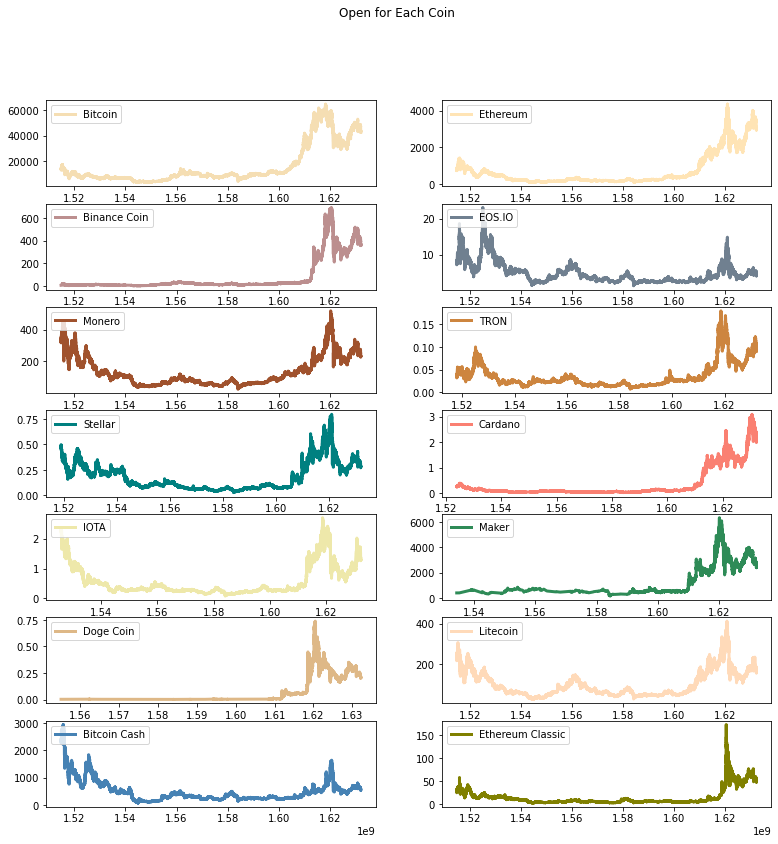

In [35]:
plt.subplots(figsize = (13,13))

plt.subplot(7,2,1)
plt.plot(btc.timestamp, btc.Open, color = 'wheat', label='Bitcoin', linewidth=3)
plt.legend(loc='upper left')

plt.subplot(7,2,2)
plt.plot(eth.timestamp, eth.Open, color='moccasin', label='Ethereum', linewidth=3)
plt.legend(loc='upper left')

plt.subplot(7,2,3)
plt.plot(bic.timestamp, bic.Open, color='rosybrown', label='Binance Coin', linewidth=3)
plt.legend(loc='upper left')

plt.subplot(7,2,4)
plt.plot(eos.timestamp, eos.Open, color='slategrey', label='EOS.IO', linewidth=3)
plt.legend(loc='upper left')

plt.subplot(7,2,5)
plt.plot(mon.timestamp, mon.Open, color='sienna', label='Monero', linewidth=3)
plt.legend(loc='upper left')

plt.subplot(7,2,6)
plt.plot(tron.timestamp, tron.Open, color='peru', label='TRON', linewidth=3)
plt.legend(loc='upper left')

plt.subplot(7,2,7)
plt.plot(stl.timestamp, stl.Open, color='teal', label='Stellar', linewidth=3)
plt.legend(loc='upper left')

plt.subplot(7,2,8)
plt.plot(car.timestamp, car.Open, color='salmon', label='Cardano', linewidth=3)
plt.legend(loc='upper left')

plt.subplot(7,2,9)
plt.plot(iota.timestamp, iota.Open, color='palegoldenrod', label='IOTA', linewidth=3)
plt.legend(loc='upper left')

plt.subplot(7,2,10)
plt.plot(mak.timestamp, mak.Open, color='seagreen', label='Maker', linewidth=3)
plt.legend(loc='upper left')

plt.subplot(7,2,11)
plt.plot(doge.timestamp, doge.Open, color='burlywood', label='Doge Coin', linewidth=3)
plt.legend(loc='upper left')

plt.subplot(7,2,12)
plt.plot(ltc.timestamp, ltc.Open, color='peachpuff', label='Litecoin', linewidth=3)
plt.legend(loc='upper left')

plt.subplot(7,2,13)
plt.plot(btcC.timestamp, btcC.Open, color='steelblue', label='Bitcoin Cash', linewidth=3)
plt.legend(loc='upper left')

plt.subplot(7,2,14)
plt.plot(ethC.timestamp, ethC.Open, color='olive', label='Ethereum Classic', linewidth=3)
plt.legend(loc='upper left')


plt.suptitle('Open for Each Coin')
##plt.xlabel('Timestamp')
##plt.ylabel('Close')

plt.legend()


plt.show() 

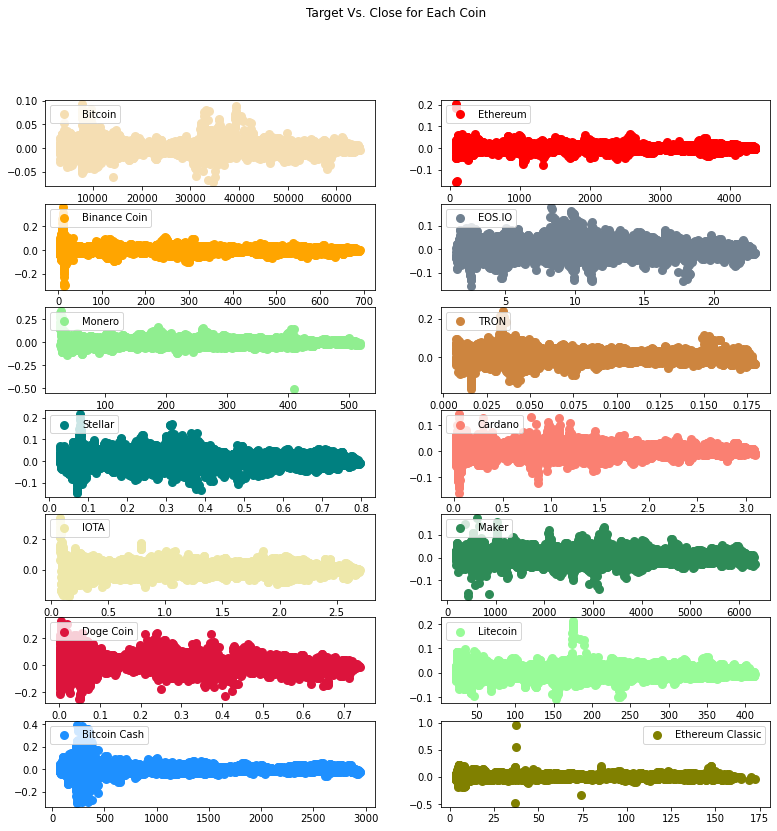

In [23]:
plt.subplots(figsize = (13,13))

plt.subplot(7,2,1)
plt.scatter(btc.Close, btc.Target, color = 'wheat', label='Bitcoin', linewidth=3)
plt.legend(loc='upper left')

plt.subplot(7,2,2)
plt.scatter(eth.Close, eth.Target, color='red', label='Ethereum', linewidth=3)
plt.legend(loc='upper left')

plt.subplot(7,2,3)
plt.scatter(bic.Close, bic.Target, color='orange', label='Binance Coin', linewidth=3)
plt.legend(loc='upper left')

plt.subplot(7,2,4)
plt.scatter(eos.Close, eos.Target, color='slategrey', label='EOS.IO', linewidth=3)
plt.legend(loc='upper left')

plt.subplot(7,2,5)
plt.scatter(mon.Close, mon.Target, color='sienna', label='Monero', linewidth=3)
plt.legend(loc='upper left')

plt.subplot(7,2,6)
plt.scatter(tron.Close, tron.Target, color='peru', label='TRON', linewidth=3)
plt.legend(loc='upper left')

plt.subplot(7,2,7)
plt.scatter(stl.Close, stl.Target, color='teal', label='Stellar', linewidth=3)
plt.legend(loc='upper left')

plt.subplot(7,2,8)
plt.scatter(car.Close, car.Target, color='salmon', label='Cardano', linewidth=3)
plt.legend(loc='upper left')

plt.subplot(7,2,9)
plt.scatter(iota.Close, iota.Target, color='palegoldenrod', label='IOTA', linewidth=3)
plt.legend(loc='upper left')

plt.subplot(7,2,10)
plt.scatter(mak.Close, mak.Target, color='seagreen', label='Maker', linewidth=3)
plt.legend(loc='upper left')

plt.subplot(7,2,11)
plt.scatter(doge.Close, doge.Target, color='crimson', label='Doge Coin', linewidth=3)
plt.legend(loc='upper left')

plt.subplot(7,2,12)
plt.scatter(ltc.Close, ltc.Target, color='peachpuff', label='Litecoin', linewidth=3)
plt.legend(loc='upper left')

plt.subplot(7,2,13)
plt.scatter(btcC.Close, btcC.Target, color='steelblue', label='Bitcoin Cash', linewidth=3)
plt.legend(loc='upper left')

plt.subplot(7,2,14)
plt.scatter(ethC.Close, ethC.Target, color='olive', label='Ethereum Classic', linewidth=3)
plt.legend(loc='upper left')


plt.suptitle('Target Vs. Close for Each Coin')
##plt.xlabel('Timestamp')
##plt.ylabel('Close')

plt.legend()


plt.show() 

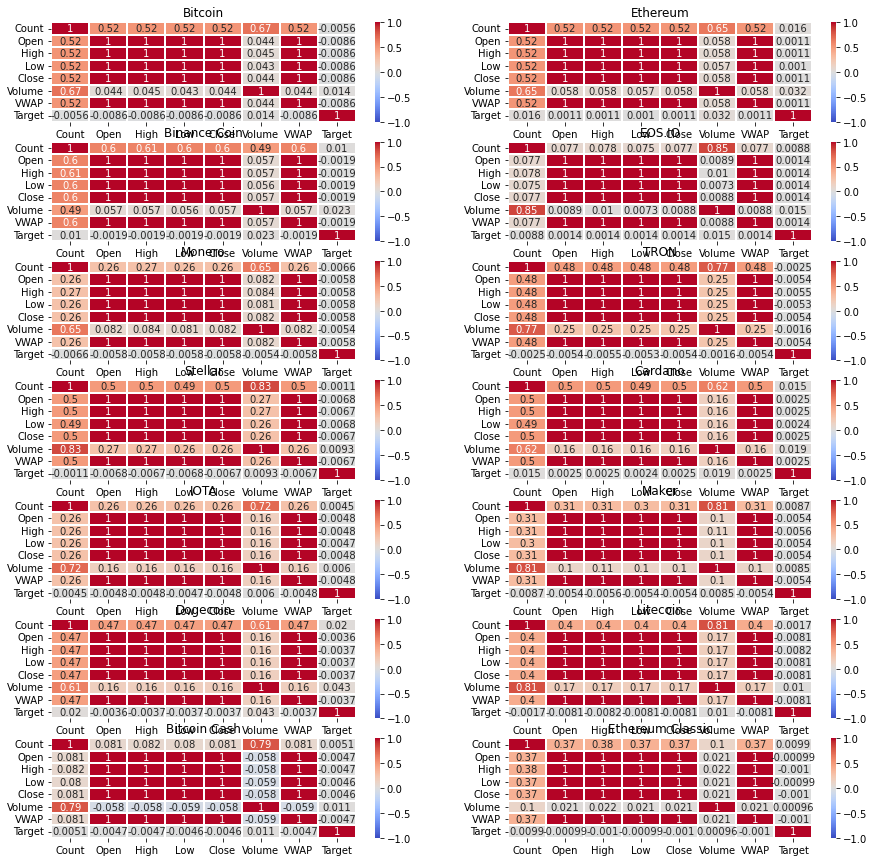

In [24]:
plt.subplots(figsize = (15,15))

plt.subplot(7,2,1)
sns.heatmap(btc[['Count','Open','High','Low','Close','Volume','VWAP','Target']].corr(), 
            vmin=-1.0, vmax=1.0, annot=True, cmap='coolwarm', linewidths=0.1)
plt.title('Bitcoin')

plt.subplot(7,2,2)
sns.heatmap(eth[['Count','Open','High','Low','Close','Volume','VWAP','Target']].corr(), 
            vmin=-1.0, vmax=1.0, annot=True, cmap='coolwarm', linewidths=0.1)
plt.title('Ethereum')

plt.subplot(7,2,3)
sns.heatmap(bic[['Count','Open','High','Low','Close','Volume','VWAP','Target']].corr(), 
            vmin=-1.0, vmax=1.0, annot=True, cmap='coolwarm', linewidths=0.1)
plt.title('Binance Coin')

plt.subplot(7,2,4)
sns.heatmap(eos[['Count','Open','High','Low','Close','Volume','VWAP','Target']].corr(), 
            vmin=-1.0, vmax=1.0, annot=True, cmap='coolwarm', linewidths=0.1)
plt.title('EOS.IO')

plt.subplot(7,2,5)
sns.heatmap(mon[['Count','Open','High','Low','Close','Volume','VWAP','Target']].corr(), 
            vmin=-1.0, vmax=1.0, annot=True, cmap='coolwarm', linewidths=0.1)
plt.title('Monero')

plt.subplot(7,2,6)
sns.heatmap(tron[['Count','Open','High','Low','Close','Volume','VWAP','Target']].corr(), 
            vmin=-1.0, vmax=1.0, annot=True, cmap='coolwarm', linewidths=0.1)
plt.title('TRON')

plt.subplot(7,2,7)
sns.heatmap(stl[['Count','Open','High','Low','Close','Volume','VWAP','Target']].corr(), 
            vmin=-1.0, vmax=1.0, annot=True, cmap='coolwarm', linewidths=0.1)
plt.title('Stellar')

plt.subplot(7,2,8)
sns.heatmap(car[['Count','Open','High','Low','Close','Volume','VWAP','Target']].corr(), 
            vmin=-1.0, vmax=1.0, annot=True, cmap='coolwarm', linewidths=0.1)
plt.title('Cardano')

plt.subplot(7,2,9)
sns.heatmap(iota[['Count','Open','High','Low','Close','Volume','VWAP','Target']].corr(), 
            vmin=-1.0, vmax=1.0, annot=True, cmap='coolwarm', linewidths=0.1)
plt.title('IOTA')

plt.subplot(7,2,10)
sns.heatmap(mak[['Count','Open','High','Low','Close','Volume','VWAP','Target']].corr(), 
            vmin=-1.0, vmax=1.0, annot=True, cmap='coolwarm', linewidths=0.1)
plt.title('Maker')

plt.subplot(7,2,11)
sns.heatmap(doge[['Count','Open','High','Low','Close','Volume','VWAP','Target']].corr(), 
            vmin=-1.0, vmax=1.0, annot=True, cmap='coolwarm', linewidths=0.1)
plt.title('Dogecoin')

plt.subplot(7,2,12)
sns.heatmap(ltc[['Count','Open','High','Low','Close','Volume','VWAP','Target']].corr(), 
            vmin=-1.0, vmax=1.0, annot=True, cmap='coolwarm', linewidths=0.1)
plt.title('Litecoin')

plt.subplot(7,2,13)
sns.heatmap(btcC[['Count','Open','High','Low','Close','Volume','VWAP','Target']].corr(), 
            vmin=-1.0, vmax=1.0, annot=True, cmap='coolwarm', linewidths=0.1)
plt.title('Bitcoin Cash')

plt.subplot(7,2,14)
sns.heatmap(ethC[['Count','Open','High','Low','Close','Volume','VWAP','Target']].corr(), 
            vmin=-1.0, vmax=1.0, annot=True, cmap='coolwarm', linewidths=0.1)
plt.title('Ethereum Classic')


plt.show()

In [67]:
X = btc[['Close','Target']].values

In [68]:
prediction_days =  60

In [69]:
scaler = MinMaxScaler(feature_range=(0,1)).fit(X)
scaled_data = scaler.transform(X)

In [70]:
scaled_data[:5]

array([[0.17351854, 0.35025569],
       [0.17316052, 0.34787695],
       [0.17272605, 0.37647088],
       [0.17218639, 0.38439005],
       [0.17148694, 0.38995329]])

In [71]:
y = [x[0] for x in scaled_data]

In [72]:
y[:5]

[0.17351853545308213,
 0.17316052253053246,
 0.17272605437028676,
 0.17218639132847646,
 0.1714869410567595]

In [73]:
split = int(len(scaled_data)*.8)
print(split)

1564782


In [74]:
X_btc = scaled_data[:split]
X_test = scaled_data[split : len(scaled_data)]
y_train = y[:split]
y_test = y[split : len(y)]

In [75]:
assert len(X_btc) == len(y_train)
assert len(X_test) == len(y_test)

In [76]:
Xbtc = []
ytrain = []
Xtest = []
ytest = []

In [79]:
for i in range(prediction_days, len(X_btc)):
    Xbtc.append(X_btc[i - prediction_days : i, : X_btc.shape[1]])
    ytrain.append(y_train[i])
for i in range(prediction_days, len(X_test)):
    Xtest.append(X_test[i - prediction_days : i, : X_test.shape[1]])
    ytest.append(y_test[i])

In [80]:
Xbtc, ytrain = (np.array(Xbtc), np.array(ytrain))
Xbtc = np.reshape(Xbtc, (Xbtc.shape[0], Xbtc.shape[1], Xbtc.shape[2]))

Xtest, ytest = (np.array(Xtest), np.array(ytest))
Xtest = np.reshape(Xtest, (Xtest.shape[0], Xtest.shape[1], Xtest.shape[2]))

In [82]:
print(Xbtc.shape)
print(ytrain.shape)
print('----')
print(Xtest.shape)
print(ytest.shape)

(1564722, 60, 2)
(1564722,)
----
(391136, 60, 2)
(391136,)


In [84]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(Xbtc.shape[1], Xbtc.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(Xbtc, ytrain, epochs=10, batch_size=100, validation_data=(Xtest, ytest), verbose = 1)

Epoch 1/10
15648/15648 [==============================] - 360s 23ms/step - loss: 3.1373e-05 - val_loss: 0.0794
Epoch 2/10
15648/15648 [==============================] - 355s 23ms/step - loss: 1.9526e-05 - val_loss: 0.1005
Epoch 3/10
15648/15648 [==============================] - 354s 23ms/step - loss: 1.8803e-05 - val_loss: 0.0981
Epoch 4/10
15648/15648 [==============================] - 324s 21ms/step - loss: 1.8285e-05 - val_loss: 0.1114
Epoch 5/10
15648/15648 [==============================] - 236s 15ms/step - loss: 1.7976e-05 - val_loss: 0.1060
Epoch 6/10
15648/15648 [==============================] - 232s 15ms/step - loss: 1.7743e-05 - val_loss: 0.0995
Epoch 7/10
15648/15648 [==============================] - 236s 15ms/step - loss: 1.7353e-05 - val_loss: 0.0948
Epoch 8/10
15648/15648 [==============================] - 232s 15ms/step - loss: 1.7251e-05 - val_loss: 0.0982
Epoch 9/10
15648/15648 [==============================] - 245s 16ms/step - loss: 1.7145e-05 - val_loss: 0.1097
E

In [103]:
trainPredict = model.predict(Xbtc)
testPredict = model.predict(Xtest)

In [104]:
trainPredict = np.c_[trainPredict, np.zeros(trainPredict.shape)]
testPredict = np.c_[testPredict, np.zeros(testPredict.shape)]

In [105]:
trainPredict = scaler.inverse_transform(trainPredict)
trainPredict = [x[0] for x in trainPredict]

testPredict = scaler.inverse_transform(testPredict)
testPredict = [x[0] for x in testPredict]

In [106]:
print(trainPredict[:5])
print(testPredict[:5])

[13637.932339633373, 13632.9443873554, 13626.777664995894, 13619.887877902043, 13608.782816346718]
[23651.16706485649, 23650.626833517486, 23650.160103040933, 23647.609623113938, 23645.91726575604]


In [108]:
from sklearn.metrics import mean_squared_error

In [109]:
trainScore = mean_squared_error([x[0][0] for x in Xbtc], trainPredict, squared = False)
print('Train Score: %.2f RMSE' % (trainScore))

testScore = mean_squared_error([x[0][0] for x in Xtest], testPredict, squared = False)
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 9107.51 RMSE
Test Score: 26620.72 RMSE


In [110]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 60, 50)            10600     
                                                                 
 dropout_6 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_7 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_7 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_8 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_8 (Dropout)         (None, 50)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                